# Embed, Encode, Attend and Predict

In [21]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import custom_attn
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

In [3]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")

# covers about 95% of input data
MAX_SENTS = 40 # maximum number of sentences per document
MAX_WORDS = 60 # maximum number of words per sentence

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100
DOC_EMBED_SIZE = 50
NUM_CLASSES = 20

BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()

## Load Vocabulary

In [4]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 40730


## Load GloVe Embeddings

In [5]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if not word2id.has_key(word):
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(40730, 300)


## Compute Document Vectors

In [6]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [7]:
def pad_or_truncate(xs, maxlen):
    if len(xs) > maxlen:
        xs = xs[len(xs) - maxlen:]
    elif len(xs) < maxlen:
        xs = ["PAD"] * (maxlen - len(xs)) + xs
    return xs

xs = ["The", "cat", "fought", "like", "a", "mouse"]
print(pad_or_truncate(xs, 3))
print(pad_or_truncate(xs, 7))

['like', 'a', 'mouse']
['PAD', 'The', 'cat', 'fought', 'like', 'a', 'mouse']


In [8]:
X = np.zeros((num_docs, MAX_SENTS, MAX_WORDS))
for docid in range(num_docs):
    text = ng_data.data[docid]
    sents = pad_or_truncate(nltk.sent_tokenize(text), MAX_SENTS)
    for sid, sent in enumerate(sents):
        words = nltk.word_tokenize(sent)
        words = pad_or_truncate(words, MAX_WORDS)
        for wid, word in enumerate(words):
            try:
                word_id = word2id[word]
            except KeyError:
                word_id = word2id["UNK"]
            X[docid, sid, wid] = word_id
print(X.shape)

(18846, 40, 60)


In [9]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [10]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 40, 60) (13192, 20) (5654, 40, 60) (5654, 20)


## Define Network

### Sentence Level

In [23]:
sent_inputs = Input(shape=(MAX_WORDS,), dtype="int32")

sent_emb = Embedding(input_dim=vocab_size,
                     output_dim=WORD_EMBED_SIZE,
#                      mask_zero=True,
                     weights=[E])(sent_inputs)
sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE,
                             return_sequences=True))(sent_emb)

sent_vec = GlobalAveragePooling1D()(sent_enc)
sent_att = custom_attn.AttentionMV()([sent_enc, sent_vec])

sent_model = Model(inputs=sent_inputs, outputs=sent_att)
sent_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 60, 300)           12219000  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 60, 200)           240600    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 200)               0         
_________________________________________________________________
attention_mv_5 (AttentionMV) (None, 200)               40200     
Total params: 12,499,800
Trainable params: 12,499,800
Non-trainable params: 0
_________________________________________________________________


In [24]:
doc_inputs = Input(shape=(MAX_SENTS, MAX_WORDS), dtype="int32")

doc_emb = TimeDistributed(sent_model)(doc_inputs)

doc_enc = Bidirectional(GRU(DOC_EMBED_SIZE,
                            return_sequences=True))(doc_emb)

doc_vec = GlobalAveragePooling1D()(doc_enc)
doc_att = custom_attn.AttentionMV()([doc_enc, doc_vec])

fc1_dropout = Dropout(0.2)(doc_att)
fc1 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc1)
doc_pred = Dense(NUM_CLASSES, activation="softmax")(fc2_dropout)

model = Model(inputs=doc_inputs, outputs=doc_pred)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 40, 60)            0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 40, 200)           12499800  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 40, 100)           75300     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 100)               0         
_________________________________________________________________
attention_mv_6 (AttentionMV) (None, 100)               10100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
__________

In [25]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

In [26]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=0.1)

Train on 11872 samples, validate on 1320 samples
Epoch 1/10


InvalidArgumentError: Matrix size-incompatible: In[0]: [153600,200], In[1]: [2560,200]
	 [[Node: time_distributed_3/attention_mv_5/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](time_distributed_3/attention_mv_5/Reshape_3, time_distributed_3/attention_mv_5/Reshape_4)]]

Caused by op u'time_distributed_3/attention_mv_5/MatMul_1', defined at:
  File "/home/sujit/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/sujit/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-114815fea735>", line 3, in <module>
    doc_emb = TimeDistributed(sent_model)(doc_inputs)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/Keras-2.0.2-py2.7.egg/keras/engine/topology.py", line 578, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/Keras-2.0.2-py2.7.egg/keras/layers/wrappers.py", line 172, in call
    y = self.layer.call(inputs)  # (num_samples * timesteps, ...)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/Keras-2.0.2-py2.7.egg/keras/engine/topology.py", line 1989, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/Keras-2.0.2-py2.7.egg/keras/engine/topology.py", line 2151, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensors, **kwargs))
  File "custom_attn.py", line 134, in call
    at = K.softmax(K.dot(ht, self.u))
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/Keras-2.0.2-py2.7.egg/keras/backend/tensorflow_backend.py", line 843, in dot
    return tf.reshape(tf.matmul(xt, yt),
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 1855, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1454, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/sujit/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Matrix size-incompatible: In[0]: [153600,200], In[1]: [2560,200]
	 [[Node: time_distributed_3/attention_mv_5/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](time_distributed_3/attention_mv_5/Reshape_3, time_distributed_3/attention_mv_5/Reshape_4)]]


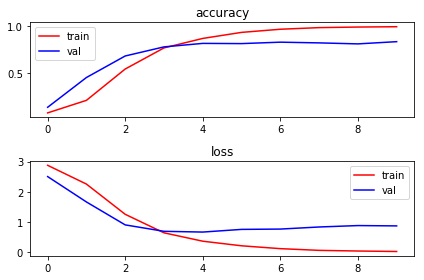

In [17]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [18]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.821

confusion matrix

[[187   1   0   0   0   0   1   1   0   0   0   2   2   2   3   5   0   8   2  41]
 [  1 204  15   8   5  16   1   4   0   0   1   4  16   2  11   0   1   0   0   2]
 [  0  19 208  16  17  16  12   2   0   0   0   1   3   0   1   1   2   1   0   0]
 [  0   3  12 191  33   5  11   2   1   1   0   1  11   3   0   1   0   0   0   0]
 [  0   3   7  34 199   4  10   3   0   0   2   1  27   1   2   0   1   0   0   0]
 [  0  16   8   2   2 251   3   0   1   1   0  13   6   0   1   0   0   0   1   0]
 [  0   5   3  17   9   0 214  11   9   3   0   0   8   1   3   1   5   0   0   0]
 [  0   2   0   1   0   0  11 235  20   2   3   3   8   1   4   0   1   0   2   0]
 [  0   0   0   0   0   0   5   5 287   1   0   0   1   2   2   0  10   0   3   0]
 [  1   0   0   1   0   0   7   1   2 274  15   0   0   0   2   3   3   1   4   1]
 [  0   1   1   1   1   0   1   1   1  10 287   0   0   2   1   0   0   0   0   0]
 [  0   1   0   0   0   1   2   0   0   0   0 